# Курсовой проект для курса "Библиотеки Python для Data Science"

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb, lightgbm as lgbm, catboost as catb
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

%matplotlib inline

In [2]:
warnings.simplefilter('ignore')

In [3]:
# Отчёт классификации
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    if y_train_true is not None:
        print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    # Поменял местами y_test_true и y_test_pred, чтобы результат был больше похож на матрицу ошибок 
    # (т.е. чтобы в строке были предсказанные значения, а в столбце реальные значения)
    print(pd.crosstab(y_test_pred, y_test_true))

In [4]:
# Построение графиков обучения
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))
    _, ax = plt.subplots(1,1)

    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [5]:
# Балансировка выборки
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [6]:
# Балансировка
def balance_df(i_X_train, i_y_train, i_target_name):
    print(i_y_train.value_counts())

    df_for_balancing = pd.concat([i_X_train, i_y_train], axis=1)
    df_balanced = balance_df_by_target(df_for_balancing, i_target_name)

    print(df_balanced[i_target_name].value_counts())

    return df_balanced.drop(columns=i_target_name), df_balanced[i_target_name]

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [8]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [9]:
PATH_TEST_DS = 'course_project_test.csv'
PATH_TRAIN_DS = 'course_project_train.csv'
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.txt'

###  Обзор обучающего датасета

In [10]:
df = pd.read_csv(PATH_TRAIN_DS)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [11]:
df.shape

(7500, 17)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [13]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Анализ целевой переменной

In [14]:
target_name = 'Credit Default'
feature_names = df.columns.drop(target_name).tolist()
all_features = feature_names + [target_name]

In [15]:
df[target_name].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

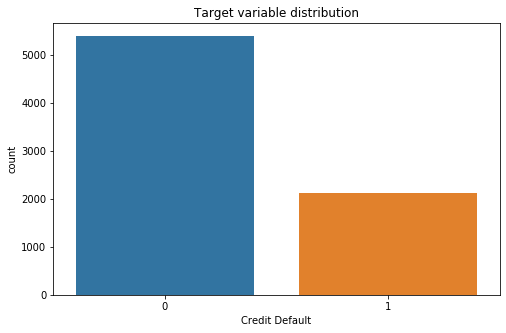

In [16]:
plt.figure(figsize=(8, 5))
sns.countplot(x=target_name, data=df)
plt.title('Target variable distribution')
plt.show()

In [17]:
target_mean = df[target_name].mean()
target_median = df[target_name].median()
target_mode = df[target_name].mode()[0]

target_mean, target_median, target_mode

(0.28173333333333334, 0.0, 0)

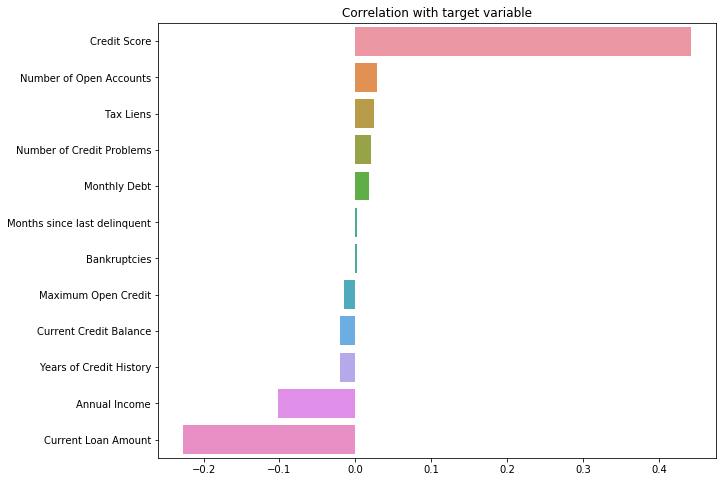

In [18]:
corr_with_target = df[feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

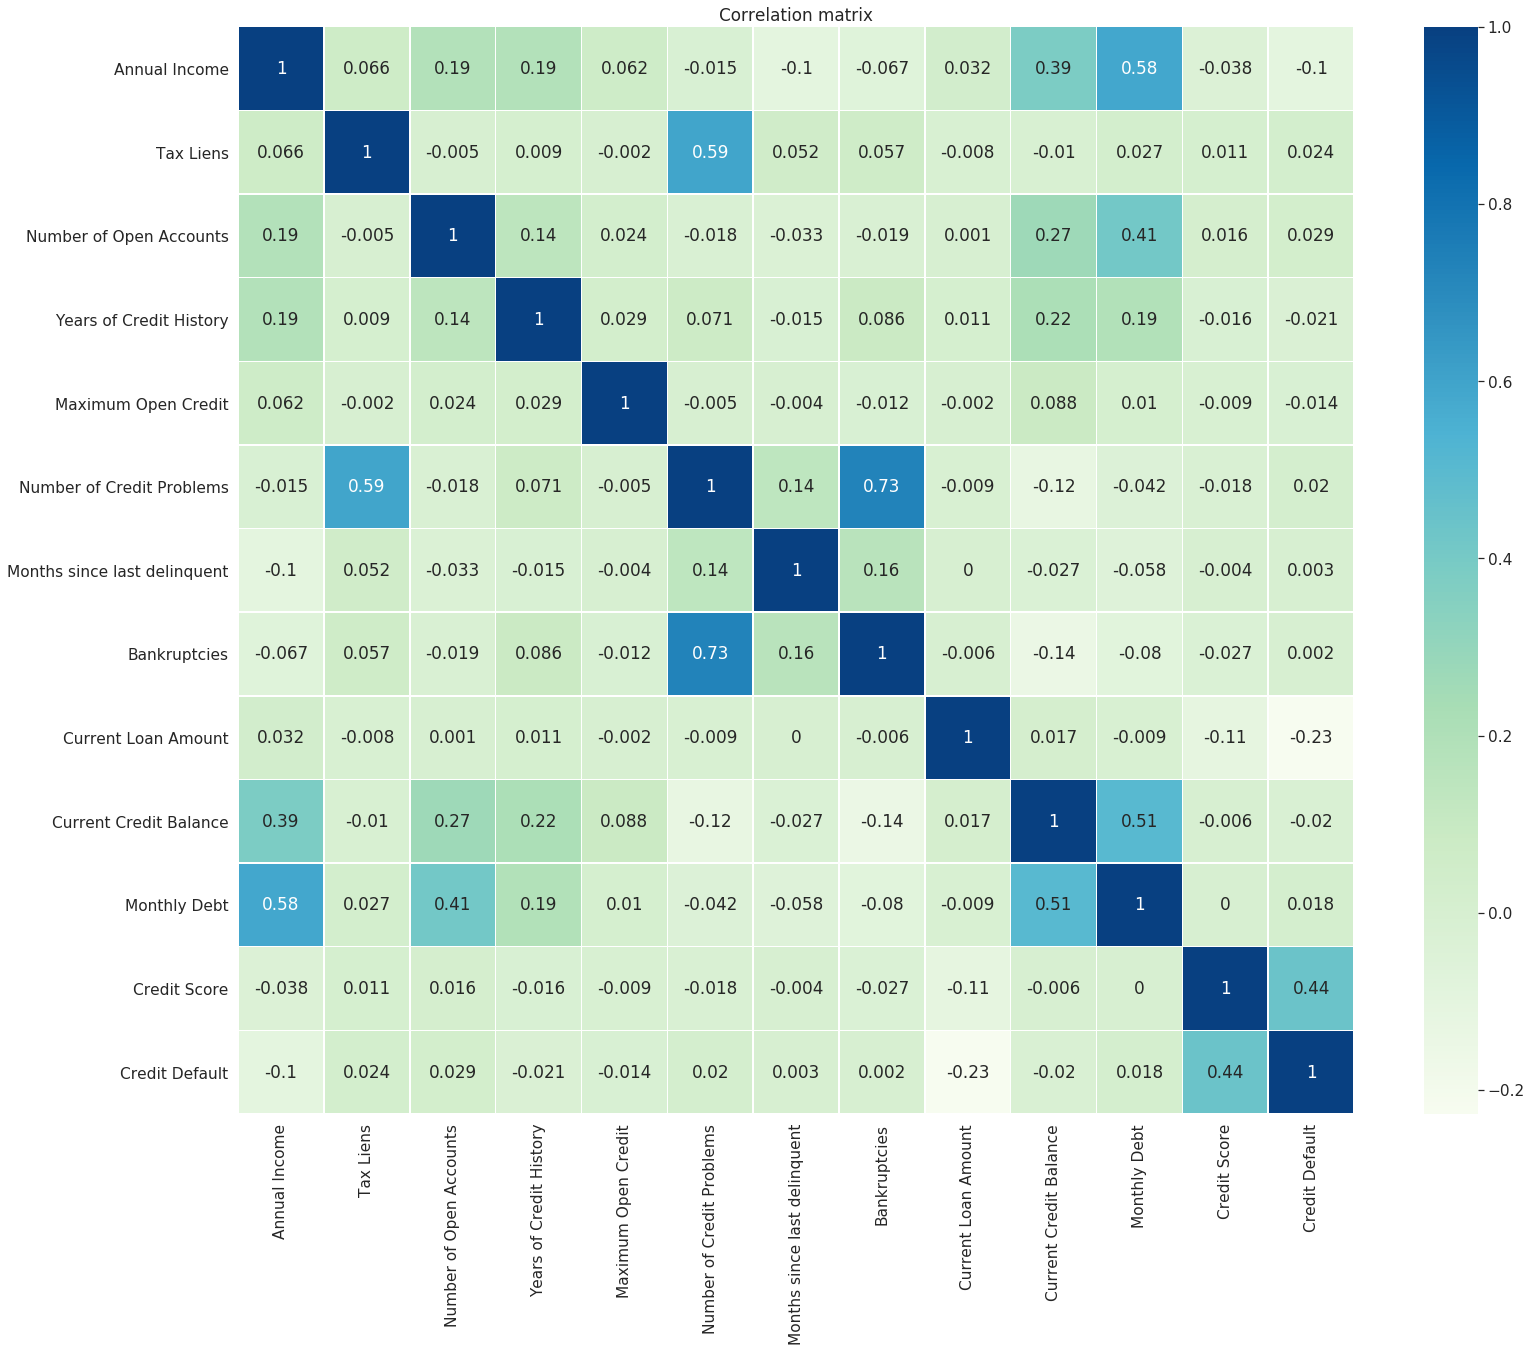

In [19]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

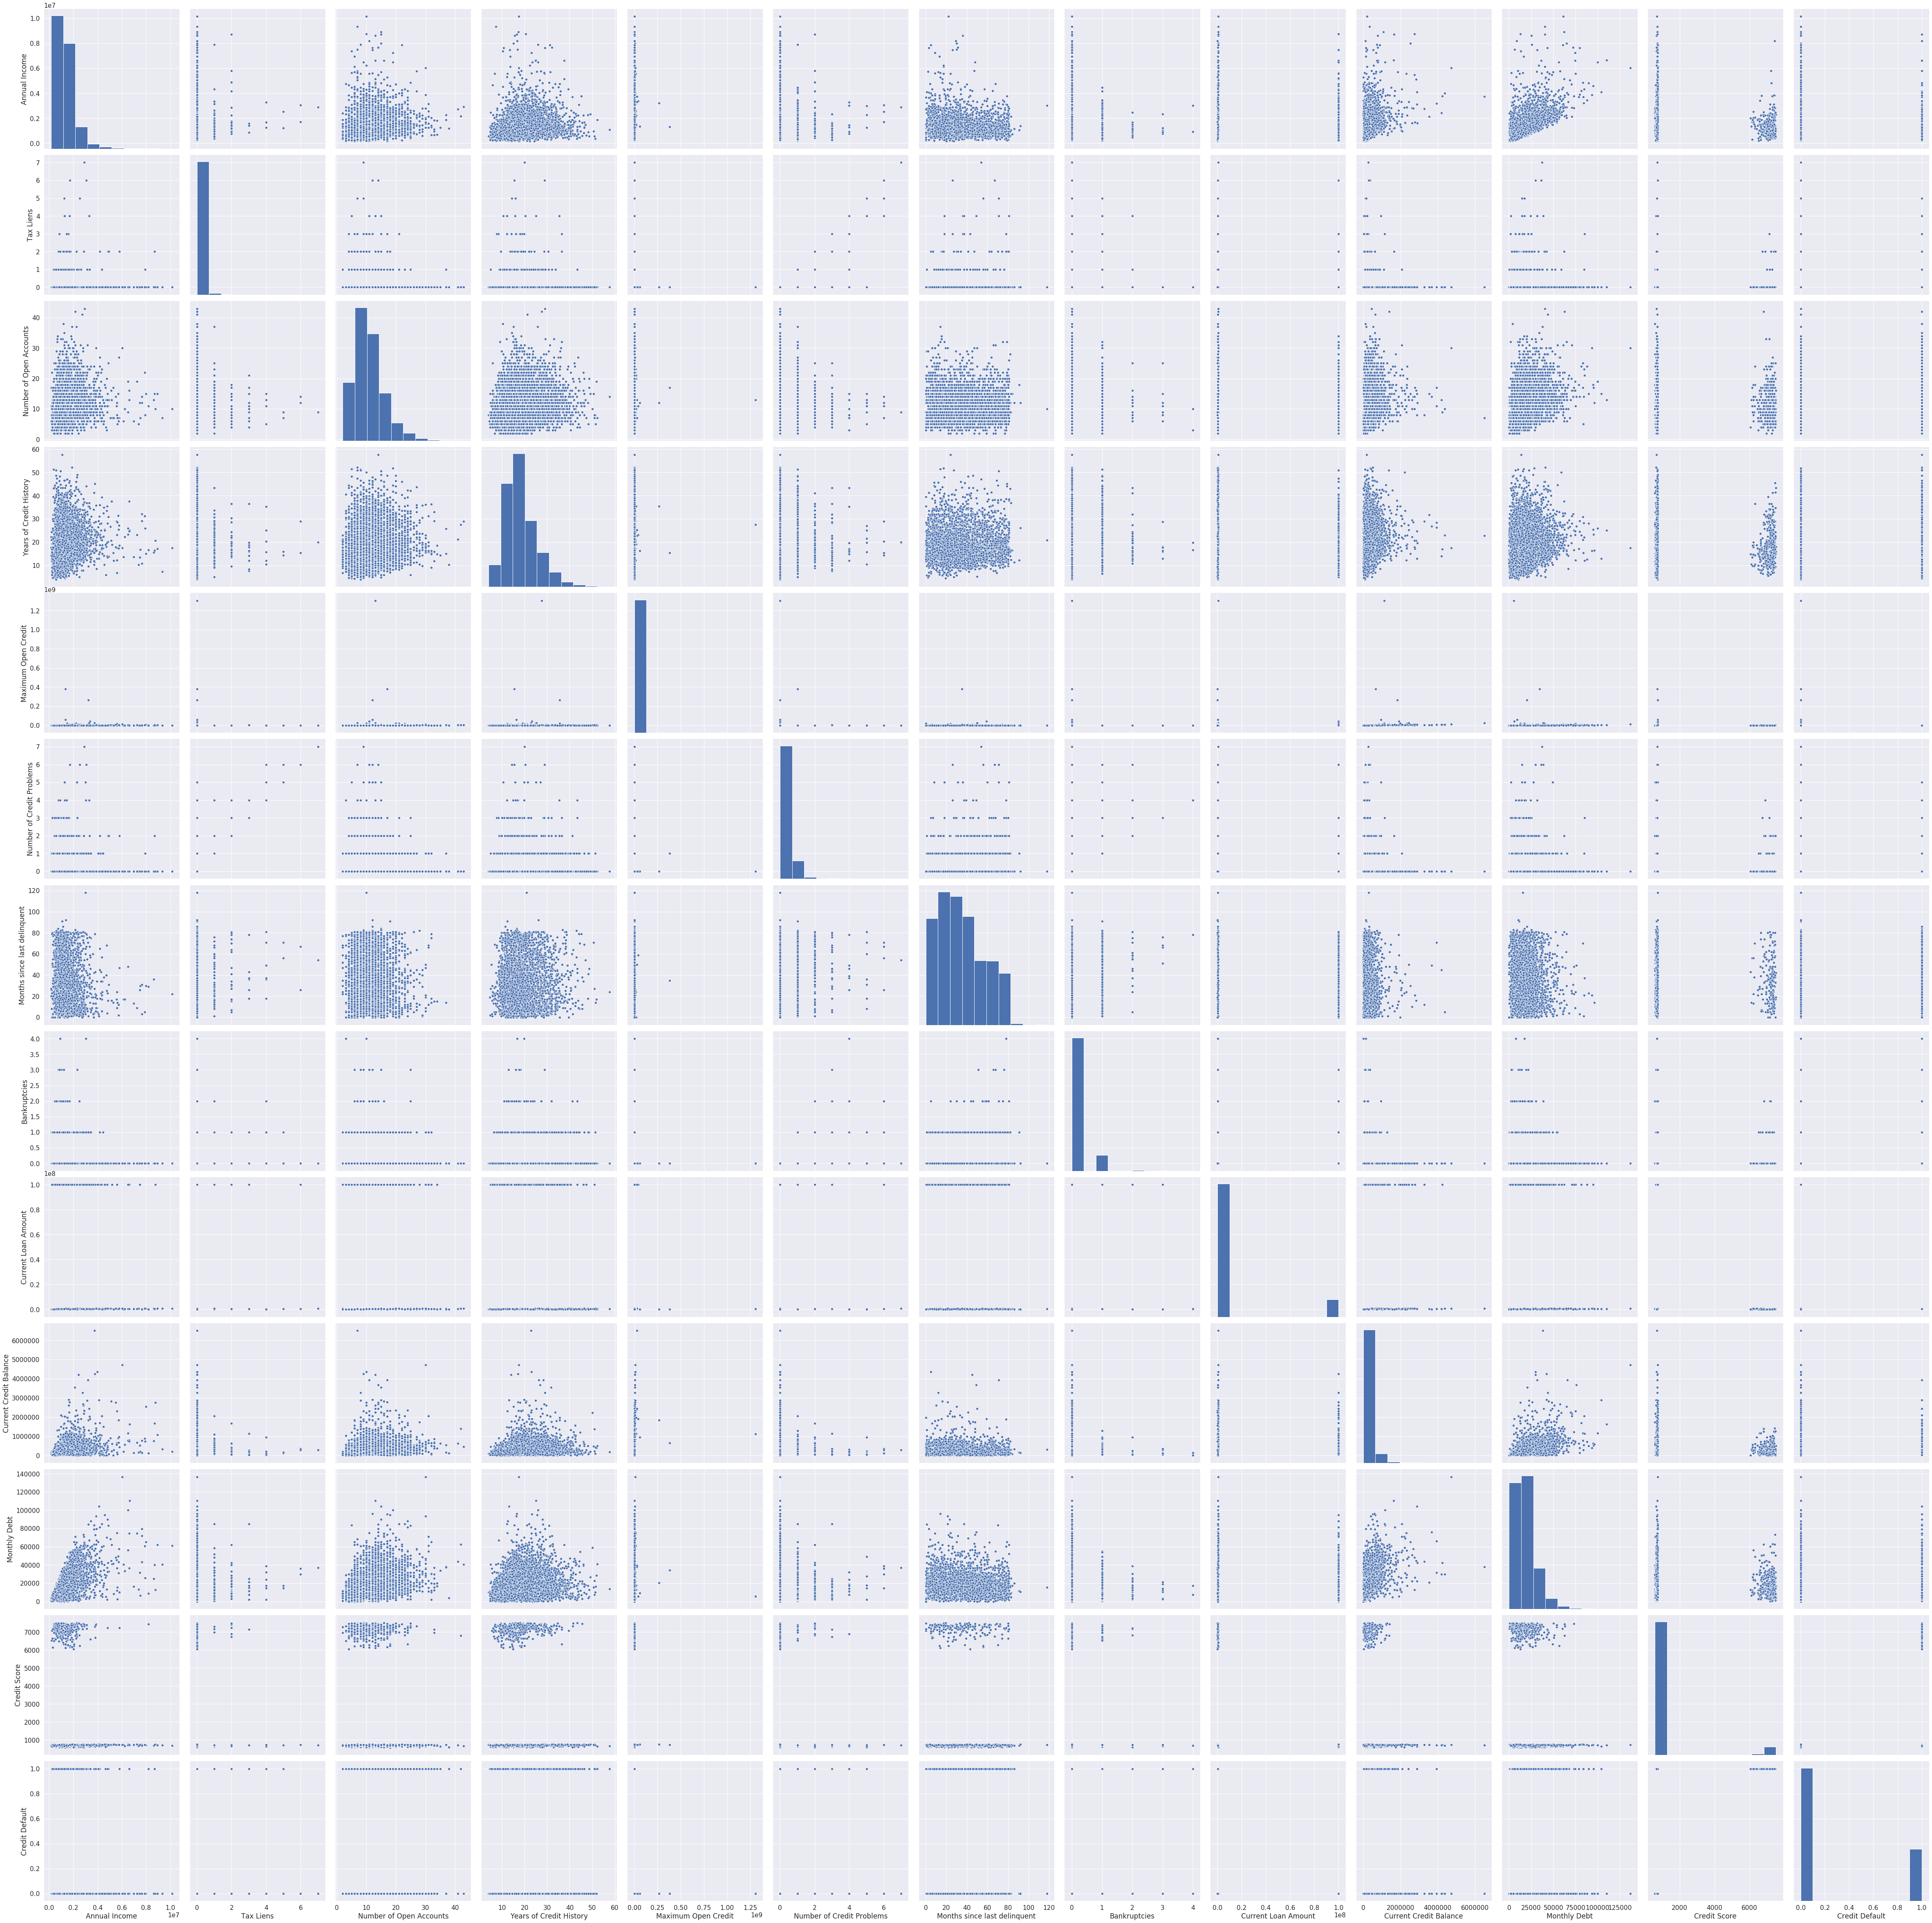

In [20]:
sns.pairplot(df, height=5)

### Обработка пропусков и построение новых признаков

In [21]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [22]:
print(len(df) - df.count())

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64


In [23]:
def get_dict_vs(i_df):
    dict_cs = {
        'CS_1000': i_df[i_df['Credit Score'] >= 1000]['Credit Default'].mean(),
        'CS_0750': i_df[(i_df['Credit Score'] >= 750) & (i_df['Credit Score'] < 1000)]['Credit Default'].mean(),
        'CS_0740': i_df[(i_df['Credit Score'] >= 740) & (i_df['Credit Score'] < 750)]['Credit Default'].mean(),
        'CS_0730': i_df[(i_df['Credit Score'] >= 730) & (i_df['Credit Score'] < 740)]['Credit Default'].mean(),
        'CS_0720': i_df[(i_df['Credit Score'] >= 720) & (i_df['Credit Score'] < 730)]['Credit Default'].mean(),
        'CS_0710': i_df[(i_df['Credit Score'] >= 710) & (i_df['Credit Score'] < 720)]['Credit Default'].mean(),
        'CS_0700': i_df[(i_df['Credit Score'] >= 700) & (i_df['Credit Score'] < 710)]['Credit Default'].mean(),
        'CS_0690': i_df[(i_df['Credit Score'] >= 690) & (i_df['Credit Score'] < 700)]['Credit Default'].mean(),
        'CS_0680': i_df[(i_df['Credit Score'] >= 680) & (i_df['Credit Score'] < 690)]['Credit Default'].mean(),
        'CS_0670': i_df[(i_df['Credit Score'] >= 670) & (i_df['Credit Score'] < 680)]['Credit Default'].mean(),
        'CS_0660': i_df[(i_df['Credit Score'] >= 660) & (i_df['Credit Score'] < 670)]['Credit Default'].mean(),
        'CS_0650': i_df[(i_df['Credit Score'] >= 650) & (i_df['Credit Score'] < 660)]['Credit Default'].mean(),
        'CS_0640': i_df[(i_df['Credit Score'] >= 640) & (i_df['Credit Score'] < 650)]['Credit Default'].mean(),
        'CS_0630': i_df[(i_df['Credit Score'] >= 630) & (i_df['Credit Score'] < 640)]['Credit Default'].mean(),
        'CS_0620': i_df[(i_df['Credit Score'] >= 620) & (i_df['Credit Score'] < 630)]['Credit Default'].mean(),
        'CS_0610': i_df[(i_df['Credit Score'] >= 610) & (i_df['Credit Score'] < 620)]['Credit Default'].mean(),
        'CS_0600': i_df[(i_df['Credit Score'] >= 600) & (i_df['Credit Score'] < 610)]['Credit Default'].mean(),
        'CS_0500': i_df[(i_df['Credit Score'] >= 500) & (i_df['Credit Score'] < 600)]['Credit Default'].mean(),
        'CS_0001': i_df[(i_df['Credit Score'] >= 1) & (i_df['Credit Score'] < 0)]['Credit Default'].mean(),
        'CS_0000': i_df[i_df['Credit Score'] < 1]['Credit Default'].mean()
        }

    for key, value in dict_cs.items():
        if value is np.nan:
            dict_cs[key] = 0
            
    return dict_cs

In [24]:
def get_dicts(i_df):
    # cat_fields  Категориальные признаки, которые будут объединены в один сильный признак
    cat_fields = list(i_df.select_dtypes(include=['uint8']).columns)
    
    return (
        cat_fields,
        # dict_cs
        get_dict_vs(i_df), 
        # dict_cs_m
        i_df[~i_df['Credit Score'].isna()].groupby(['Credit Score']).\
            agg({'Credit Default':'mean'})['Credit Default'].sort_index(), 
        #i_df[~i_df['Credit Score'].isna()].groupby(['Credit Score'], as_index=False).\
        #    agg({'Credit Default':'mean'}).rename(columns={'Credit Default':'CS_CD'})
        # dict_ai_med
        i_df.groupby(['Years in current job']).agg({'Annual Income':'median'})[ \
            'Annual Income'].to_dict(), 
        # dict_cat_m
        i_df.groupby(cat_fields, as_index=False).agg({'Credit Default':'mean'}).rename( \
            columns={'Credit Default':'Cat'})
    )

In [25]:
# Обработка признаков часть 1
def processing1(i_df, i_dict_ycj):
    i_df['Years in current job'] = i_df['Years in current job'].apply(lambda x: i_dict_ycj.get(x, -1)) #0)) # -1))
    i_df.loc[i_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = -1 #0 #-1
    i_df.loc[i_df['Bankruptcies'].isna(), 'Bankruptcies'] = -1 #0 #-1
    i_df.loc[i_df['Credit Score'].isna(), 'Credit Score'] = -1
    i_df['Credit Score > 5000'] = ((i_df['Credit Score']>5000)*1).astype(np.uint8)
    i_df['Current Loan Amount 99999999'] = ((i_df['Current Loan Amount']==99999999)*1).astype(np.uint8)
    
    #i_df['Maximum Open Credit 0'] = ((i_df['Maximum Open Credit']==0)*1).astype(np.uint8)
    #i_df['Number of Credit Problems 0'] = ((i_df['Number of Credit Problems']==0)*1).astype(np.uint8)
    #i_df['Tax Liens 0'] = ((i_df['Tax Liens']==0)*1).astype(np.uint8)
    
    #i_df['Number of Credit Problems'] = (i_df['Number of Credit Problems']).astype(np.uint8)
    #i_df['Tax Liens'] = (i_df['Tax Liens']).astype(np.uint8)
    #i_df['Bankruptcies'] = (i_df['Bankruptcies']).astype(np.uint8)
    #i_df['Number of Open Accounts'] = (i_df['Number of Open Accounts']).astype(np.uint8)
    #i_df['Years in current job'] = (i_df['Years in current job']).astype(np.uint8)
    #i_df['Months since last delinquent'] = (i_df['Months since last delinquent']).astype(np.uint8)
    #i_df.loc[i_df['Annual Income'].isna(), 'Annual Income'] = ai_med
    i_df = pd.get_dummies(i_df, drop_first=True)
    
    return i_df

In [26]:
# Обработка признаков часть 2
def processing2(i_df, i_dict_ai_med, i_dict_cs_m, i_dict_cat_m, i_cat_fields, dict_cs):
    # Добавим категориальные поля которых нет в тестовой выборке
    test_fields = list(i_df.select_dtypes(include=['uint8']).columns)
    for f in [item for item in i_cat_fields if item not in test_fields]:
        i_df[f] = 0
    
    i_df.loc[i_df['Annual Income'].isna(), 'Annual Income'] = i_df.loc[i_df['Annual Income'].isna(), \
        'Years in current job'].apply(lambda x: i_dict_ai_med.get(x))    

    i_df['Credit Score Default'] = i_df['Credit Score'].apply(lambda x: \
        i_dict_cs_m.iat[i_dict_cs_m.index.searchsorted(x, side='left')])
    #i_df = i_df.merge(i_dict_cs_m, on='Credit Score', how='left')
    
    i_df = i_df.merge(i_dict_cat_m, on=i_cat_fields, how='left')
    i_df = i_df.drop(columns=i_cat_fields)
   
    i_df.loc[i_df['Cat'].isna(), 'Cat'] = -1
    
    i_df['CS'] = i_df['Credit Score'].apply(lambda x: dict_cs.get( \
        'CS_1000' if x >= 1000 else 
        'CS_0750' if (x >= 750) & (x < 1000) else 
        'CS_0740' if (x >= 740) & (x < 750) else 
        'CS_0730' if (x >= 730) & (x < 740) else 
        'CS_0720' if (x >= 720) & (x < 730) else 
        'CS_0710' if (x >= 710) & (x < 720) else 
        'CS_0700' if (x >= 700) & (x < 710) else 
        'CS_0690' if (x >= 690) & (x < 700) else 
        'CS_0680' if (x >= 680) & (x < 690) else 
        'CS_0670' if (x >= 670) & (x < 680) else 
        'CS_0660' if (x >= 660) & (x < 670) else 
        'CS_0650' if (x >= 650) & (x < 660) else 
        'CS_0640' if (x >= 640) & (x < 650) else 
        'CS_0630' if (x >= 630) & (x < 640) else 
        'CS_0620' if (x >= 620) & (x < 630) else 
        'CS_0610' if (x >= 610) & (x < 620) else 
        'CS_0600' if (x >= 600) & (x < 610) else 
        'CS_0500' if (x >= 500) & (x < 600) else 
        'CS_0001' if (x >= 1) & (x < 0) else 
        'CS_0000' ))  
    
    return i_df

In [27]:
# Обработка датасетов

# Сохраним полную копию данных
df_copy = df.copy()
# Сразу выделим отдельно тестовую часть
df, df_ttest = train_test_split(df, test_size=0.3, random_state=21, shuffle=True)

# Заменим категориальный признак 'Years in current job' на числовой
dict_ycj = { '< 1 year': 0, 
             '1 year': 1, 
             '2 years': 2, 
             '3 years': 3, 
             '4 years': 4,
             '5 years': 5, 
             '6 years': 6,
             '7 years': 7,
             '8 years': 8, 
             '9 years': 9,
             '10+ years': 10
           }

# Обработка 1
df = processing1(df, dict_ycj)
cat_fields, dict_cs, dict_cs_m, dict_ai_med, dict_cat_m = get_dicts(df)
# Обработка 2
df = processing2(df, dict_ai_med, dict_cs_m, dict_cat_m, cat_fields, dict_cs)

# Обработка для теста
df_ttest = processing1(df_ttest, dict_ycj)
df_ttest = processing2(df_ttest, dict_ai_med, dict_cs_m, dict_cat_m, cat_fields, dict_cs)

In [28]:
#df.hist(figsize=(16,16), bins=20, grid=False)

In [29]:
##X_train_bal['Credit Default'] = y_train_bal
#data = df #X_train_bal

#cat_feature_names = data.select_dtypes(include=['uint8']).columns
#for colname in cat_feature_names:
#    sns.countplot(x=colname, hue='Credit Default', data=data)
#    plt.legend(title='Target', loc='upper right')
#    plt.show()

### Приведение типов данных

In [30]:
#df.select_dtypes(include=['uint8'])

In [31]:
# Категориальные признаки
#cat_feature_names = df.select_dtypes(include=['uint8']).columns
#for colname in cat_feature_names:
#    df[colname] = pd.Categorical(df[colname])

In [32]:
#df[cat_feature_names].dtypes

### Стандартизация признаков

In [33]:
#stand_feature_names = df.columns.drop(target_name).tolist()
#scaler = StandardScaler()
#df[stand_feature_names] = scaler.fit_transform(df[stand_feature_names])

In [34]:
#df.describe()

In [35]:
#with open(SCALER_FILE_PATH, 'wb') as file:
#    pickle.dump(scaler, file)

## Обучение CatBoostClassifier

In [36]:
feature_names = df.columns.drop([target_name]).tolist()
all_features = feature_names + [target_name]

In [37]:
def call_CBC(i_X_train, i_y_train, i_X_test, i_y_test):
    cat_features = []
    #for fn in cat_feature_names:
    #    cat_features.append(feature_names.index(fn))

    #params = {'n_estimators': [100, 500, 1000],
    #          'max_depth': [2, 3, 4],
    #          'l2_leaf_reg': [3, 5, 10, 15]
    #         }

    params = {'n_estimators': [1000],
              'max_depth': [3]
             }

    cbc_model = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=cat_features, 
                                        class_weights=[1, 2.5]
                                       )

    gs = GridSearchCV(cbc_model, params, scoring='f1', cv=KFold(n_splits=3, random_state=21, shuffle=True), 
                      n_jobs=-1)
    gs.fit(i_X_train, i_y_train)

    print("best_score:", gs.best_score_)
    print("best_params:", gs.best_params_)

    y_train_pred = gs.best_estimator_.predict(i_X_train)
    y_test_pred = gs.best_estimator_.predict(i_X_test)

    get_classification_report(i_y_train, y_train_pred, i_y_test, y_test_pred)

    important_features_top = show_feature_importances(i_X_train.columns, gs.best_estimator_.feature_importances_, 
                                                      get_top=15)    
    #plot_grid_search(gs.cv_results_, params['n_estimators'], params['max_depth'], 'n_estimators', 'max_depth')
    
    return gs.best_estimator_, important_features_top

In [38]:
#X = df[feature_names]
#y = df[target_name]
#X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)
X_train = df[feature_names]
y_train = df[target_name]
X_test = df_ttest[feature_names]
y_test = df_ttest[target_name]

# Балансировка
#X_train_bal, y_train_bal = balance_df(X_train, y_train, target_name)

best_score: 0.5619478124793572
best_params: {'max_depth': 3, 'n_estimators': 1000}
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      3771
           1       0.59      0.76      0.66      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.78      0.75      5250
weighted avg       0.81      0.78      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1616
           1       0.48      0.61      0.54       634

    accuracy                           0.70      2250
   macro avg       0.65      0.67      0.66      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

Credit Default     0    1
row_0                    
0               1190  245
1                426  389


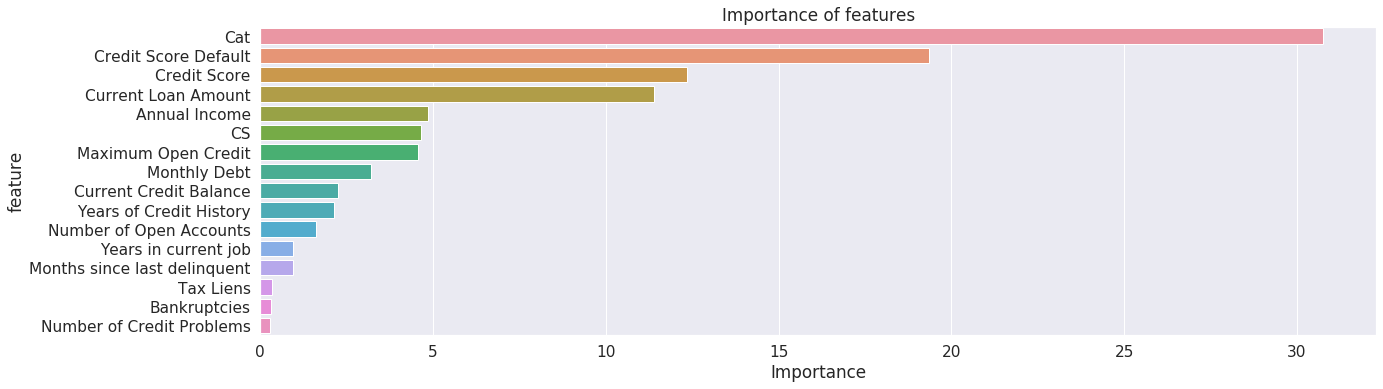

CPU times: user 24.5 s, sys: 812 ms, total: 25.3 s
Wall time: 8.03 s


In [39]:
%%time
# Обучаем первую модель
#best_model, important_features_top = call_CBC(X_train_bal, y_train_bal, X_test, y_test)
best_model, important_features_top = call_CBC(X_train, y_train, X_test, y_test)

In [40]:
# Выбираем самые важные признаки из первой модели
#X = df[important_features_top]
#y = df[target_name]
#X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)
X_train = df[important_features_top]
y_train = df[target_name]
X_test = df_ttest[important_features_top]
y_test = df_ttest[target_name]

# Балансировка
#X_train_bal, y_train_bal = balance_df(X_train, y_train, target_name)

best_score: 0.5631905626254688
best_params: {'max_depth': 3, 'n_estimators': 1000}
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      3771
           1       0.59      0.76      0.66      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.77      0.75      5250
weighted avg       0.81      0.78      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1616
           1       0.47      0.62      0.54       634

    accuracy                           0.70      2250
   macro avg       0.65      0.67      0.66      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

Credit Default     0    1
row_0                    
0               1183  243
1                433  391


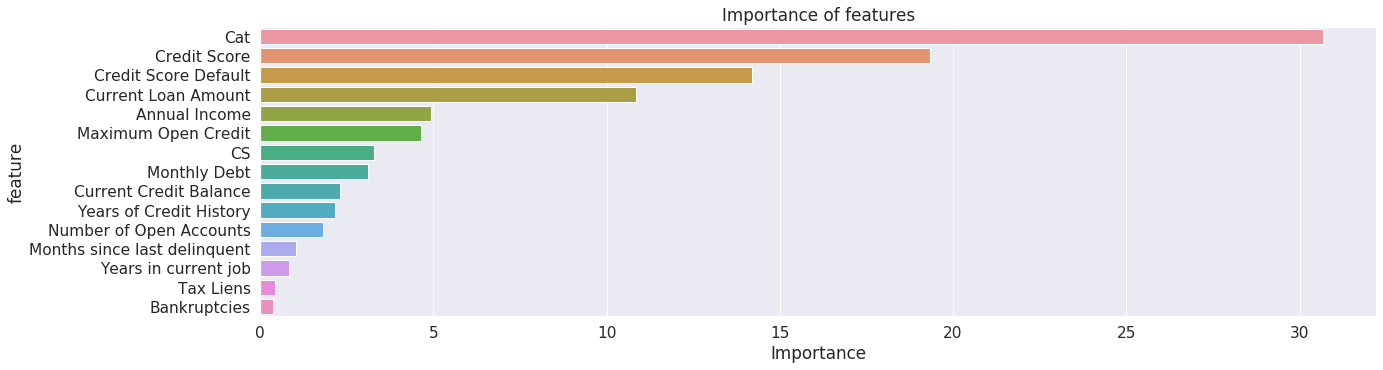

CPU times: user 22.2 s, sys: 513 ms, total: 22.7 s
Wall time: 7.22 s


In [41]:
%%time
# Обучаем вторую модель на самых важных признаках
#best_model, _ = call_CBC(X_train_bal, y_train_bal, X_test, y_test)
best_model, _ = call_CBC(X_train, y_train, X_test, y_test)

In [42]:
# Посчитаем скор на всей выборке
df_copy_test = df_copy.copy()
df_copy_test = processing1(df_copy_test, dict_ycj)
df_copy_test = processing2(df_copy_test, dict_ai_med, dict_cs_m, dict_cat_m, cat_fields, dict_cs)

X_test = df_copy_test[important_features_top]
y_test = df_copy_test[target_name]

get_classification_report(None, None, y_test, best_model.predict(X_test))

TEST

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      5387
           1       0.55      0.72      0.62      2113

    accuracy                           0.76      7500
   macro avg       0.71      0.74      0.72      7500
weighted avg       0.78      0.76      0.77      7500

CONFUSION MATRIX

Credit Default     0     1
row_0                     
0               4165   601
1               1222  1512


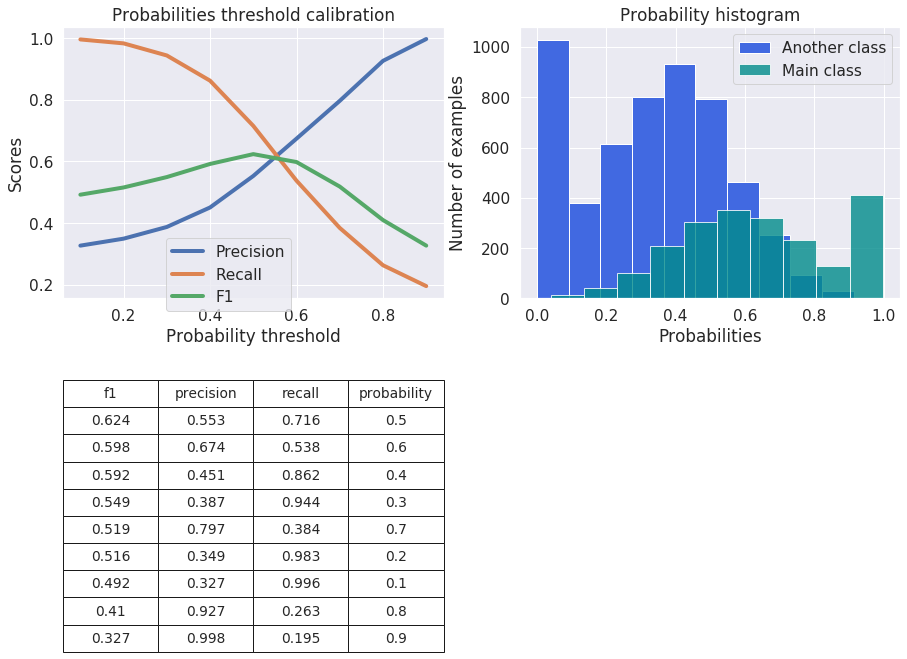

In [43]:
y_test_pred_probs = best_model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [44]:
#f1_score(y_test, list(map(int, y_test_pred_probs[:, 1] > 0.5)))

best_score: 0.5717812402285195
best_params: {'max_depth': 3, 'n_estimators': 1000}
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      5387
           1       0.57      0.74      0.65      2113

    accuracy                           0.77      7500
   macro avg       0.73      0.76      0.74      7500
weighted avg       0.80      0.77      0.78      7500

TEST

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      5387
           1       0.57      0.74      0.65      2113

    accuracy                           0.77      7500
   macro avg       0.73      0.76      0.74      7500
weighted avg       0.80      0.77      0.78      7500

CONFUSION MATRIX

Credit Default     0     1
row_0                     
0               4213   541
1               1174  1572


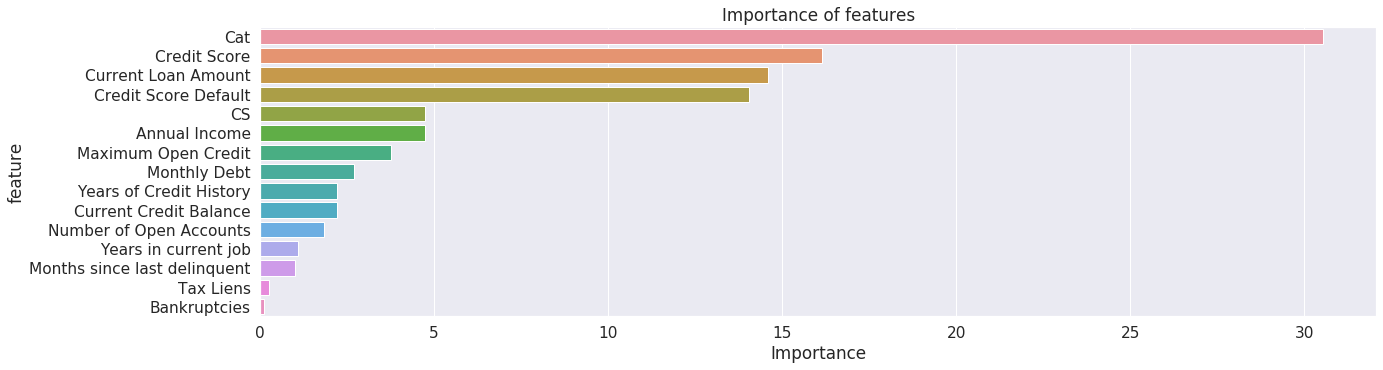

CPU times: user 24.1 s, sys: 454 ms, total: 24.6 s
Wall time: 9.56 s


In [45]:
%%time

# Обучим модель на всей выборке
df_copy = processing1(df_copy, dict_ycj)
cat_fields, dict_cs, dict_cs_m, dict_ai_med, dict_cat_m = get_dicts(df_copy)
df_copy = processing2(df_copy, dict_ai_med, dict_cs_m, dict_cat_m, cat_fields, dict_cs)

X = df_copy[important_features_top]
y = df_copy[target_name]

# Балансировка
#X_bal, y_bal = balance_df(X, y, target_name)

# Обучаем финальную модель
#final_model, _ = call_CBC(X_bal, y_bal, X_bal, y_bal)
final_model, _ = call_CBC(X, y, X, y)

In [46]:
#with open(MODEL_FILE_PATH, 'wb') as file:
#    pickle.dump(final_model, file)

## Предскажем классы для тестовой выборки и запишем результаты в файл

In [47]:
df_test = pd.read_csv(PATH_TEST_DS)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [48]:
df_test = processing1(df_test, dict_ycj)
df_test = processing2(df_test, dict_ai_med, dict_cs_m, dict_cat_m, cat_fields, dict_cs)

In [49]:
y_pred = final_model.predict(df_test[important_features_top])
result = pd.DataFrame({ 'Credit Default': y_pred })
result.head()

,Credit Default
0,1
1,1
2,1
3,0
4,0


In [50]:
result.to_csv('RSemenov_predictions.csv', sep=',', index=True, encoding='utf-8')

In [51]:
#print(len(df_test) - df_test.count())
#print(len(df_ttest) - df_ttest.count())